
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-u3r70rsb
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-u3r70rsb
     |████████████████████████████████| 5.6 MB 5.0 MB/s 
     |████████████████████████████████| 117 kB 40.3 MB/s 
     |████████████████████████████████| 180 kB 44.0 MB/s 
     |████████████████████████████████| 76 kB 3.9 MB/s 
     |████████████████████████████████| 131 kB 44.9 MB/s 
     |████████████████████████████████| 32.8 MB 135 kB/s 
     |████████████████████████████████| 79 kB 4.2 MB/s 
     |████████████████████████████████| 8.5 MB 35.3 MB/s 
     |████████████████████████████████| 138 kB 53.8 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 5.1 MB 40.1 MB/s 
     |████████████████████████████████| 127 kB 42.3 MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-py3-n

In [34]:
#@title
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [44]:
#This dataset contains 20647 amazon reviews for 836 data-science related books. 
#https://www.kaggle.com/vvorotnikov/amazon-data-science-book-reviews
df = pandas.read_csv('/content/reviews.csv')
df.head(5)

,stars,comment,book_url
0,5.0,"Let me say at the outset of this review, that ...",https://www.amazon.com/dp/1492041130
1,1.0,Its Capitalism at its best. I read the book fr...,https://www.amazon.com/dp/1492041130
2,5.0,If you're looking to get started with data sci...,https://www.amazon.com/dp/1492041130
3,4.0,"In general, this is a good book. It covers a w...",https://www.amazon.com/dp/1492041130
4,5.0,I was an academic data scientist decades befor...,https://www.amazon.com/dp/1492041130


In [45]:
df = df[:500]

In [38]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
dfVects = ngCountVectorizer.fit_transform(df['comment'])

In [39]:
dfTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
dfTFVects = dfTFVectorizer.fit_transform(df['comment'])

In [14]:
#@title
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

In [57]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(dfTFVects.toarray())
reduced_data = pca.transform(dfTFVects.toarray())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


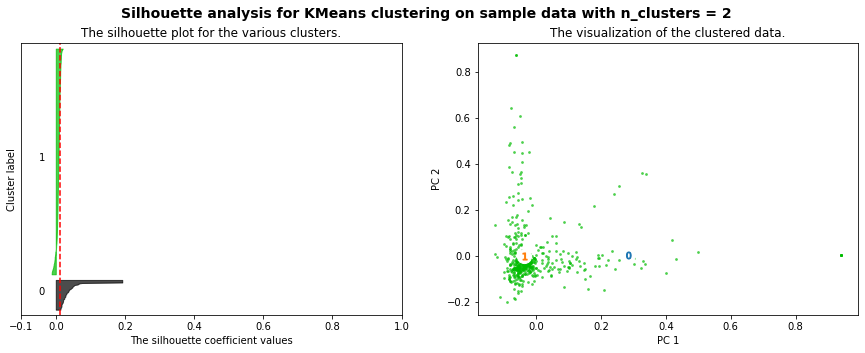

For n_clusters = 2, The average silhouette_score is : 0.012


In [58]:
X = dfTFVects.toarray()
plotSilhouette(2, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


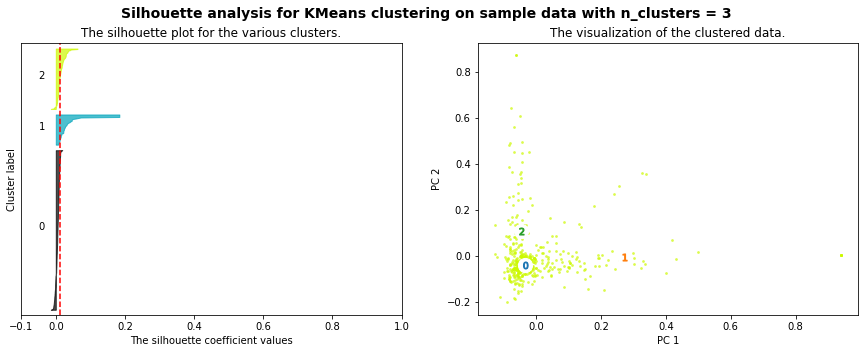

For n_clusters = 3, The average silhouette_score is : 0.011


In [59]:
X = dfTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


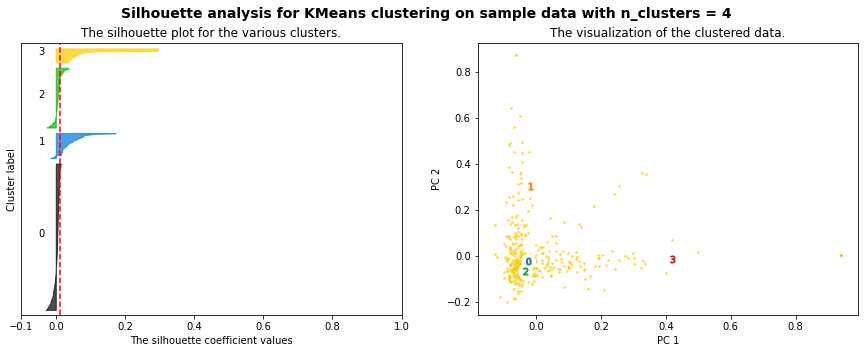

For n_clusters = 4, The average silhouette_score is : 0.013


In [60]:
X = dfTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


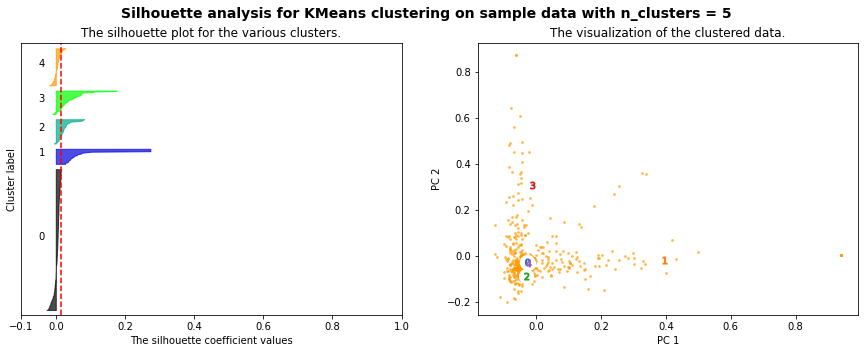

For n_clusters = 5, The average silhouette_score is : 0.015


In [61]:
X = dfTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


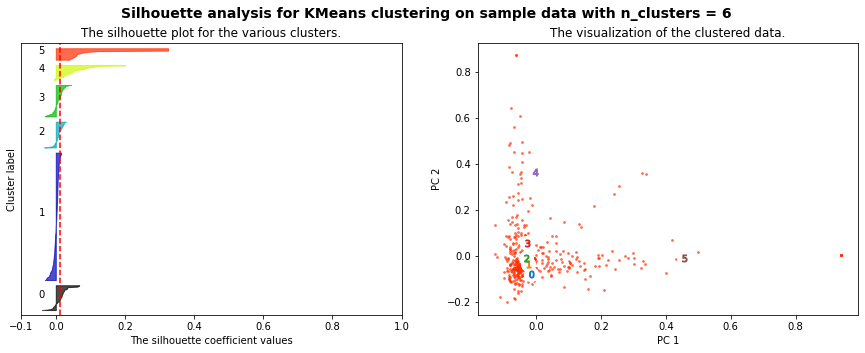

For n_clusters = 6, The average silhouette_score is : 0.013


In [63]:
X = dfTFVects.toarray()
plotSilhouette(6, X)

according to the silhouette score, n_clusters = 5 is optimal.  

In [66]:
dfKM = sklearn.cluster.KMeans(n_clusters = 5, init='k-means++')
dfKM.fit(dfTFVects)

KMeans(n_clusters=5)

In [68]:
dfPCA = sklearn.decomposition.PCA(n_components = 2).fit(dfTFVects.toarray())
reducedPCA_data = dfPCA.transform(dfTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, 5)))
colors_p = [colors[l] for l in dfKM.labels_]

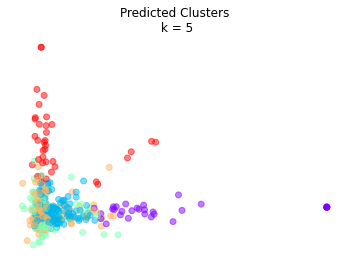

In [69]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(5))
plt.show()

<font color="yellow">The structure reveals that the documents in my corpus can be reasonably grouped into 5 clusters, which well reflects the ground truth (reviews have ratings from 1 to 5 stars).However, these clusters don't seem to show clear boundaries, meaning the content in the clusters have much overlap. It is reasonable because we don't expect reviews with different ratings to be completely different. They should have some words or sentences in common, especially those that are close in scale. </font>    

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [72]:
dfTFVects.todense()

matrix([[0.        , 0.13160943, 0.        , ..., 0.18424841, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [40]:
dfCoocMat = dfTFVects * dfTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
dfCoocMat.setdiag(0)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [41]:
selectIndices = []
indexToCat = []
for c in set(df['stars']):
    selectIndices += list(df[df['stars'] == c].index)[:50]
    indexToCat += [c] * 50

In [51]:
subCoocMat = dfCoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 21.        ,  93.        ,   0.        ,   2.        ],
       [ 35.        , 168.        ,   0.36302549,   3.        ],
       [  4.        , 116.        ,   0.3938493 ,   2.        ],
       [ 33.        , 169.        ,   0.43252508,   4.        ],
       [ 88.        , 146.        ,   0.43954858,   2.        ],
       [ 38.        , 163.        ,   0.44348144,   2.        ],
       [ 75.        , 102.        ,   0.46151662,   2.        ],
       [ 74.        , 171.        ,   0.47922721,   5.        ],
       [172.        , 174.        ,   0.48581043,   4.        ],
       [ 11.        , 131.        ,   0.48630655,   2.        ]])

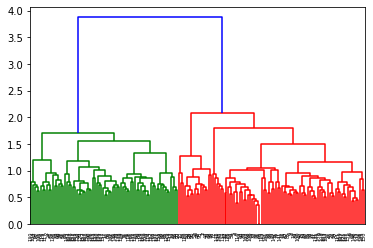

In [43]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

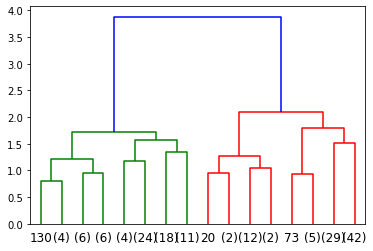

In [71]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=3, truncate_mode='level', get_leaves=True)

<font color="yellow"> The colors of the dendrogram indicate that two clusters are distant from each other.</font> 

In [61]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(dfCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 2, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['stars'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['stars'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['stars'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df['stars'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.015
Completeness: 0.052
V-measure: 0.023
Adjusted Rand Score: -0.012


/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


<font color="yellow"> The nested cluster structure reveals that the documents in my corpus can be grouped into two distinct clusters that are distant from each other. The HCA does a worse job than K-means because it clusters based on the distance/similarity among the documents. Since a lot of the book reviews share similar content and only reviews with a rating of 1 and a rating of 5 are polarized enough to be assigned into a different cluster, it makes sense that the HCA does worse than k-means. </font> 

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [98]:
#The dataset contains listings of 745 brands that include all the brand's slogans 
#https://www.kaggle.com/thomaskonstantin/known-brands-slogans-and-risk-assessment
slogans = pandas.read_csv('/content/Slogans.csv')

In [ ]:
slogans.head(5)

In [103]:
slogans['tokenized_text'] = slogans['Slogan'].apply(lambda x: lucem_illud.word_tokenize(str(x)))
slogans['normalized_tokens'] = slogans['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
slogans.head(3)

In [121]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

slogans['reduced_tokens'] = slogans['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [122]:
slogans.head(3)

,Brand,Slogan,Raw_Revenue_Info,identical_trademarks,simillar_trademarks,social_media_taken,domains_point_to_website,tokenized_text,normalized_tokens,reduced_tokens
0,Audi,Never Follow.\nKeeping ahead through technolog...,"For the reporting period, the Audi Group's pro...",13,1751,3,5,"[Never, Follow, Keeping, ahead, through, techn...","[follow, keep, ahead, technology, dream, audi,...","[follow, technology, dream, dream, india, luxu..."
1,Apple,Company advertising campaigns\nByte into an Ap...,"Cupertino, California — October 29, 2020 — App...",30,1134,3,9,"[Company, advertising, campaigns, Byte, into, ...","[company, advertise, campaign, byte, apple, la...","[company, advertise, campaign, apple, late, 19..."
2,American Airlines,The new American is arriving.\nBe yourself. No...,"22, 2020 (GLOBE NEWSWIRE) -- American Airlines...",10,686,2,8,"[The, new, American, is, arriving, Be, yoursel...","[new, american, arrive, nonstop, know, fly, sp...","[arrive, fly, spanish, airline, airline, proud..."


In [123]:
dictionary = gensim.corpora.Dictionary(slogans['reduced_tokens'])

In [124]:
corpus = [dictionary.doc2bow(text) for text in slogans['reduced_tokens']]

In [174]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, alpha=0.01, eta=0.01)

In [175]:
#@title
topicsDict = {}
for topicNum in range(lda.num_topics):
    topicWords = [w for w, p in lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,drive,baby,fly,clean,coffee
1,water,thing,love,thing,bank
2,fresh,car,car,happy,love
3,airline,choice,sport,price,style
4,eat,enjoy,airline,fresh,total
5,car,think,break,discover,drive
6,food,apple,share,buy,fun
7,blue,brand,easy,fun,pure
8,fly,natural,think,feel,healthy
9,love,love,travel,road,price


<Figure size 432x288 with 0 Axes>

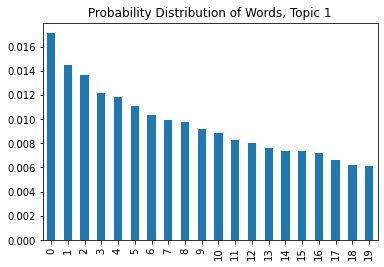

In [177]:
topic1_df = pandas.DataFrame(lda.show_topic(1, topn=20))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [178]:
##different beta 
lda2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, alpha=0.01, eta = 0.9)
topicsDict = {}
for topicNum in range(lda2.num_topics):
    topicWords = [w for w, p in lda2.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,love,car,coffee,style,bank
1,coffee,fly,fresh,clean,baby
2,car,drive,airline,performance,thing
3,drive,fun,road,easy,price
4,apple,love,think,share,value
5,price,slogan,food,air,tool
6,pure,cat,car,ice,think
7,computer,discover,campaign,earth,trust
8,pleasure,line,water,love,beautiful
9,thing,tool,love,late,big


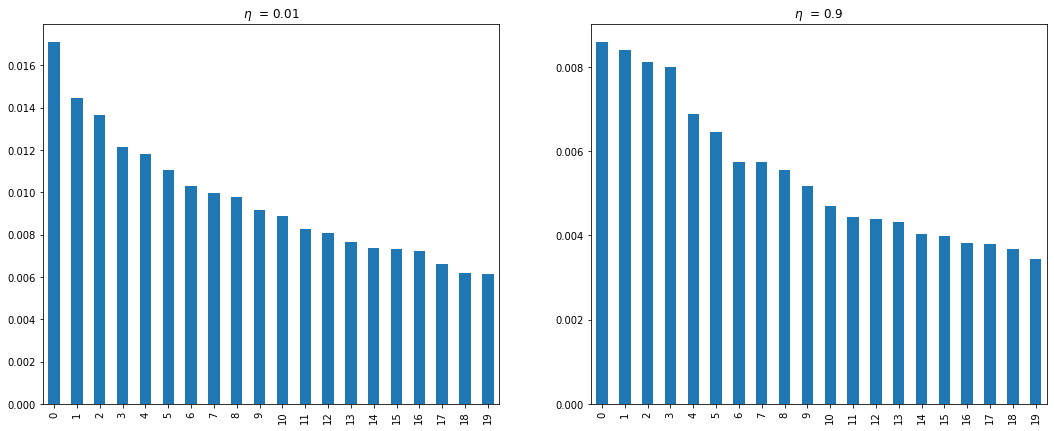

In [179]:
topic1_df = pandas.DataFrame(lda.show_topic(1, topn=20))
topic2_df = pandas.DataFrame(lda2.show_topic(1, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.01')
topic2_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [180]:
##different alpha
lda3 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, alpha=0.9, eta = 0.01)
topicsDict = {}
for topicNum in range(lda3.num_topics):
    topicWords = [w for w, p in lda3.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,love,coffee,airline,car,coffee
1,think,love,fly,drive,love
2,food,clean,love,price,sport
3,drive,fun,tool,fun,style
4,fresh,car,pure,thing,fly
5,thing,think,fun,fresh,car
6,fast,fresh,car,love,fresh
7,hot,drive,think,pleasure,drive
8,water,thing,drive,beautiful,think
9,eat,try,sport,bank,easy


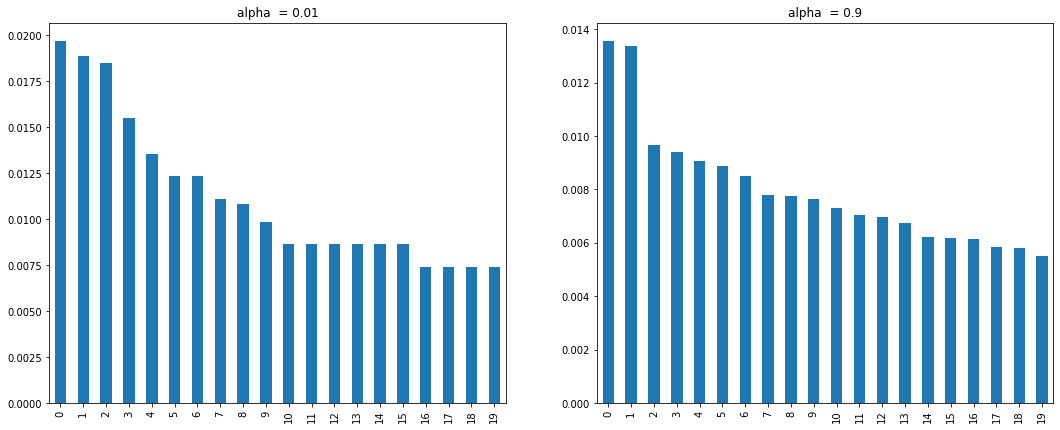

In [207]:
topic1_df = pandas.DataFrame(lda.show_topic(0, topn=20))
topic3_df = pandas.DataFrame(lda3.show_topic(0, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.01')
topic3_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

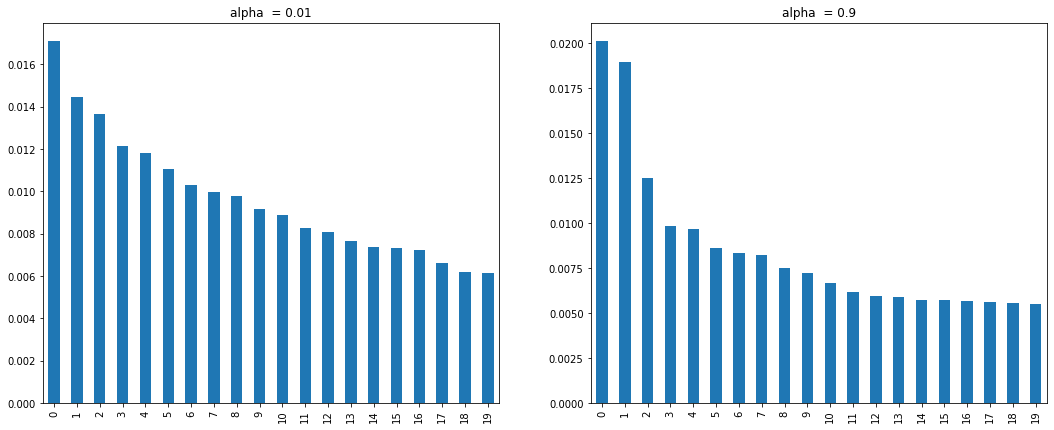

In [181]:
topic1_df = pandas.DataFrame(lda.show_topic(1, topn=20))
topic3_df = pandas.DataFrame(lda3.show_topic(1, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.01')
topic3_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

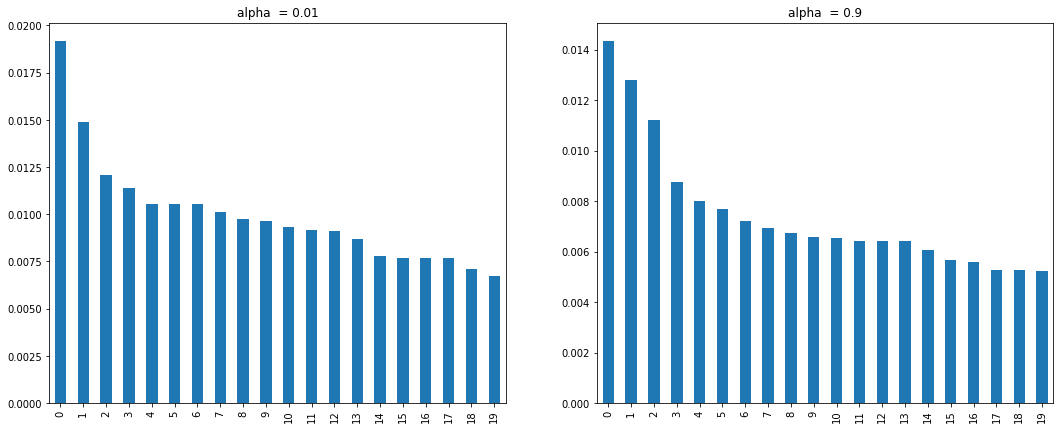

In [203]:
topic1_df = pandas.DataFrame(lda.show_topic(2, topn=20))
topic3_df = pandas.DataFrame(lda3.show_topic(2, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.01')
topic3_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

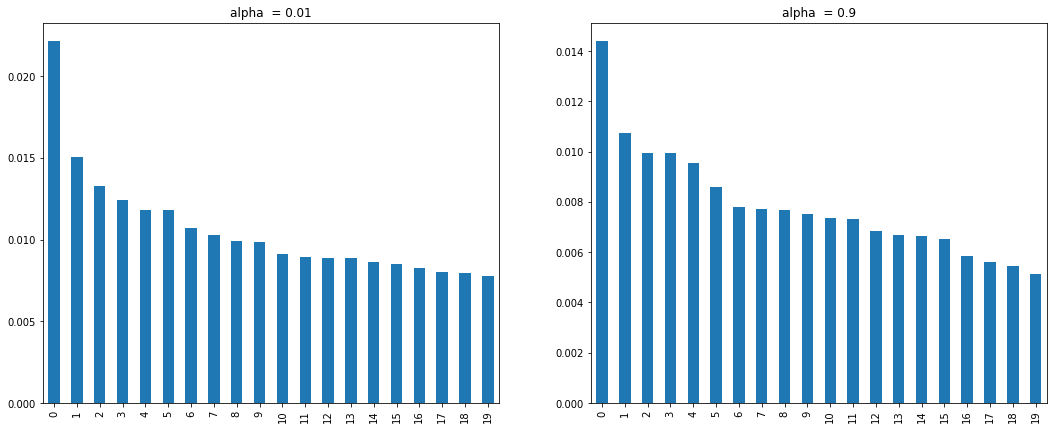

In [204]:
topic1_df = pandas.DataFrame(lda.show_topic(3, topn=20))
topic3_df = pandas.DataFrame(lda3.show_topic(3, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.01')
topic3_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

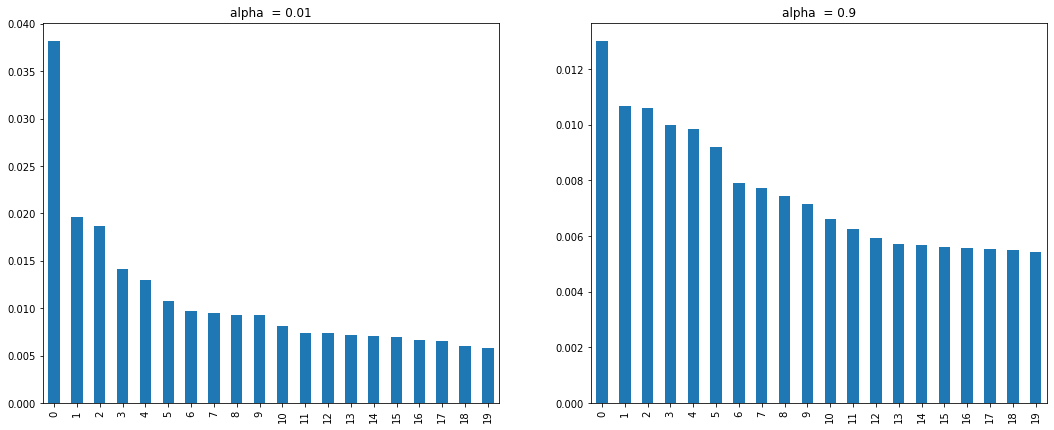

In [205]:
topic1_df = pandas.DataFrame(lda.show_topic(4, topn=20))
topic3_df = pandas.DataFrame(lda3.show_topic(4, topn=20))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic1_df.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.01')
topic3_df.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.9')
plt.show()

<font color="yellow"> As I increased eta from 0.01 to 0.9, the weights were more evenly distributed across the top words. The probability of the occurance for the 1st top word reduced from 0.016 to 0.008. The increase of alpha didn't change the distribution by much. However, I did notice that when the alpha was at 0.01, most of the weights fell into topic 4. In contrast, when alpha was increased to 0.9, the weights put on each topic were more balanced. </font>    



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [208]:
#The dataset contains book overview of the "Top 200 best-selling books" from Barnes & Noble
#between 2011 and 2020 
books = pd.read_csv("/content/B&N_ALL_TEXTS.csv")

In [209]:
books.head(5)

,Unnamed: 0,Text,Year
0,0,From Caldecott Honor artist Melissa Sweet come...,2011
1,1,From a New York Times bestselling and Hugo awa...,2011
2,2,"A masterpiece of postwar Polish literature, St...",2011
3,3,From the #1 New York Times-bestselling author ...,2011
4,4,Book one of the New York Times-bestselling All...,2011


In [212]:
books['tokenized_text'] = books['Text'].apply(lambda x: lucem_illud.word_tokenize(str(x)))

In [213]:
books['normalized_tokens'] = books['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [219]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [221]:
stopwords = nltk.corpus.stopwords.words('english')
customized = ['book', 'books','read', 'story','stories','character','characters', 'help', 'author', 'authors',
               'write','much','many','little','less','im','time','times','new','york','one','best','bestselling', 
              'year', 'like','first','people','even','also','america','american','novel','readers','us','review','one',
              'two','three','four','five','years','makes','make','written','writing','way','reviews','never']
stopwords = stopwords + customized
    
books['normalized_tokens'] = books['normalized_tokens'].apply(lambda x: [i for i in x if i not in stopwords])

In [222]:
books.head(5)

,Unnamed: 0,Text,Year,tokenized_text,normalized_tokens
0,0,From Caldecott Honor artist Melissa Sweet come...,2011,"[From, Caldecott, Honor, artist, Melissa, Swee...","[caldecott, honor, artist, melissa, sweet, com..."
1,1,From a New York Times bestselling and Hugo awa...,2011,"[From, a, New, York, Times, bestselling, and, ...","[hugo, award, win, come, modern, masterwork, s..."
2,2,"A masterpiece of postwar Polish literature, St...",2011,"[A, masterpiece, of, postwar, Polish, literatu...","[masterpiece, postwar, polish, literature, sto..."
3,3,From the #1 New York Times-bestselling author ...,2011,"[From, the, 1, New, York, Times, bestselling, ...","[lincoln, highway, gentleman, moscow, sharply,..."
4,4,Book one of the New York Times-bestselling All...,2011,"[Book, one, of, the, New, York, Times, bestsel...","[soul, trilogy—""a, wonderfully, imaginative, g..."


In [245]:
b1 = books.loc[books['Year'] == 2015].sample(10)
b2 = books.loc[books['Year'] == 2016].sample(10)
b3 = books.loc[books['Year'] == 2017].sample(10)
b4 = books.loc[books['Year'] == 2018].sample(10)
sub_df = pd.concat([b1,b2,b3,b4], axis = 0)

In [238]:
sub_df.head(5)

,Unnamed: 0,Text,Year,tokenized_text,normalized_tokens
963,163,NEW YORK TIMES BESTSELLER • LONGLISTED FOR THE...,2015,"[NEW, YORK, TIMES, BESTSELLER, LONGLISTED, FOR...","[bestseller, longlisted, national, award, man,..."
969,169,"""A novel as significant as it is engrossing."" ...",2015,"[A, novel, as, significant, as, it, is, engros...","[significant, engross, booklist, star, reviewg..."
966,166,NATIONAL BOOK CRITICS CIRCLE AWARD WINNER • NA...,2015,"[NATIONAL, BOOK, CRITICS, CIRCLE, AWARD, WINNE...","[national, critic, circle, award, winner, name..."
824,24,This stunning debut novel about grief and wond...,2015,"[This, stunning, debut, novel, about, grief, a...","[stun, debut, grief, wonder, instant, bestsell..."
803,3,Breq and her crew must stand against an old an...,2015,"[Breq, and, her, crew, must, stand, against, a...","[breq, crow, stand, old, powerful, enemy, lord..."


In [226]:
from gensim.models import ldaseqmodel
from gensim import corpora, models

In [246]:
dictionary = corpora.Dictionary([i for i in sub_df['normalized_tokens']])

In [247]:
corpus = [dictionary.doc2bow(text) for text in sub_df['normalized_tokens']]

In [253]:
time_slice = sub_df.groupby('Year')['Text'].count().to_list()

In [254]:
for i in range(len(time_slice)):
    print("Documents in Time Slice {}:".format(i), time_slice[i])

Documents in Time Slice 0: 10
Documents in Time Slice 1: 10
Documents in Time Slice 2: 10
Documents in Time Slice 3: 10


In [257]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [258]:
ldaseq.print_topics(time=0)[1]

[('west', 0.01881045101645164),
 ('funny', 0.011909367286066222),
 ('humor', 0.009085976583284057),
 ('woman', 0.0085127158864082),
 ('laugh', 0.008189289954696923),
 ('fantasy', 0.007732134326624206),
 ('dawson', 0.006839203069875817),
 ('hearne', 0.00681809923619974),
 ('writer', 0.006712841690190077),
 ('internet', 0.006409232275749368),
 ('shrill', 0.006365082567120934),
 ('feminist', 0.0059689922341569545),
 ('fat', 0.005968033534981534),
 ('reader', 0.004977488549573255),
 ('fun', 0.0047494677086753825),
 ('well', 0.004683576481909775),
 ('lindy', 0.004672613754159309),
 ('hilarious', 0.0046077672646148244),
 ('tale', 0.004531193863215003),
 ('william', 0.004505123122533624)]

In [262]:
ldaseq.print_topics(time=1)[1]

[('west', 0.01877546104943811),
 ('funny', 0.012115396944446447),
 ('humor', 0.009192090617707776),
 ('woman', 0.008415010212721851),
 ('laugh', 0.00827584555517008),
 ('fantasy', 0.007895080107160552),
 ('dawson', 0.006898553240064428),
 ('hearne', 0.0068865004762101185),
 ('writer', 0.006770524644521473),
 ('internet', 0.006461978692259991),
 ('shrill', 0.00641607464210281),
 ('fat', 0.006011842351110577),
 ('feminist', 0.006008246228741999),
 ('reader', 0.004993209896887223),
 ('fun', 0.004776156532662442),
 ('lindy', 0.004697056703274552),
 ('well', 0.004673322405738295),
 ('hilarious', 0.004633927779560741),
 ('tale', 0.00453402481617963),
 ('william', 0.0045292617163652064)]

In [261]:
ldaseq.print_topics(time=2)[1]

[('west', 0.018425121791435677),
 ('funny', 0.012143786126196637),
 ('humor', 0.009233356632269036),
 ('laugh', 0.008562237179006515),
 ('fantasy', 0.008281773953989352),
 ('woman', 0.00810424758758143),
 ('dawson', 0.0071747941223087525),
 ('hearne', 0.007170133454890209),
 ('writer', 0.006606353449159459),
 ('internet', 0.006285228438258822),
 ('shrill', 0.006272761522363907),
 ('fat', 0.005887251478670752),
 ('feminist', 0.005858042432022901),
 ('reader', 0.005017808891809368),
 ('fun', 0.004902002894792873),
 ('well', 0.004643664850528632),
 ('william', 0.004641554734036697),
 ('boy', 0.0046407665446066585),
 ('tale', 0.004624202216083021),
 ('lindy', 0.00460797963668627)]

In [263]:
ldaseq.print_topics(time=3)[1]

[('west', 0.01809632935173119),
 ('funny', 0.011982981412170177),
 ('humor', 0.009265333134233198),
 ('fantasy', 0.008674004038627874),
 ('laugh', 0.008669183322899116),
 ('woman', 0.007797273959604027),
 ('hearne', 0.00749338390407276),
 ('dawson', 0.0074920329307165325),
 ('writer', 0.006401878766075576),
 ('internet', 0.006100657422341928),
 ('shrill', 0.006086760070983044),
 ('fat', 0.005736732220228497),
 ('feminist', 0.0056942620160672025),
 ('reader', 0.0050446068056949536),
 ('fun', 0.005028966860044304),
 ('boy', 0.004768840567178025),
 ('william', 0.004768348575608225),
 ('tale', 0.004726687301664506),
 ('well', 0.004609513389869855),
 ('hilarious', 0.004515789139541132)]

<font color="yellow"> A small subset of the corpus, which contains 10 randomly drawn documents from each year of 2015-2018, was used. The topics look quite similar throughout the years, only the order of the topics changed a little bit. Based on the results, we can still observe that people were demanding more easy read or fantasy books over time. We see that the topic word "fantasy" moved up the rank and the word "hilarious" was added to the list. </font>    